In [1]:
import pandas as pd
import numpy as np

from src.OLS import OLS
from src.StandardScaler import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

# mpl.rcParams['figure.dpi'] = 300

import seaborn as sns

from src.stat_tests import KS2Sample, AR1, BootstrapKS2Samp, VIF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf


def bn_dollar_fmt(x, pos):
    # sign as string
    sign = "" if np.sign(x) >= 0 else "−"
    return f"{sign}${abs(x):,.0f} Bn"

def pct_fmt(x, pos):
    return f"{x:.2%}"

In [2]:
s = StandardScaler()
rgdp = pd.read_csv('./data/fred/GDPC1.csv', low_memory=False, encoding='utf-8')
cpi = pd.read_csv('./data/fred/CPIAUCSL.csv', low_memory=False, encoding='utf-8')
unrate = pd.read_csv('./data/fred/UNRATE.csv', low_memory=False, encoding='utf-8')
dff = pd.read_csv('./data/fred/DFF.csv', low_memory=False, encoding='utf-8')
tcu = pd.read_csv('./data/fred/TCU.csv', low_memory=False, encoding='utf-8')

set = [rgdp, cpi, unrate, dff, tcu]
for df in set:
    df.set_index("observation_date", inplace=True)

rgdp = rgdp.pct_change().dropna()
cpi = cpi.pct_change().dropna()
tcu = tcu.pct_change().dropna()

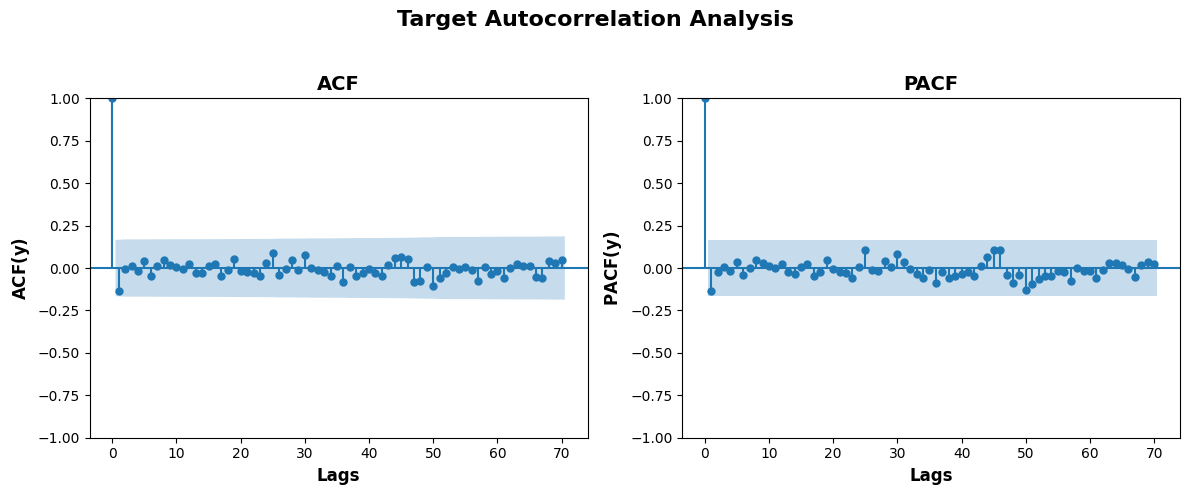

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(rgdp, ax[0], lags=70)
ax[0].set_title(r"ACF", fontsize=14, weight='bold')
ax[0].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[0].set_ylabel(r"$\mathbf{ACF(y)}$", fontsize=12, weight='bold')

plot_pacf(rgdp, ax[1], lags=70)
ax[1].set_title(r"PACF", fontsize=14, weight='bold')
ax[1].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[1].set_ylabel(r"$\mathbf{PACF(y)}$", fontsize=12, weight='bold')
plt.suptitle(r"Target Autocorrelation Analysis", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./paper/fig/acf_pacf.png', dpi=300)
plt.show()


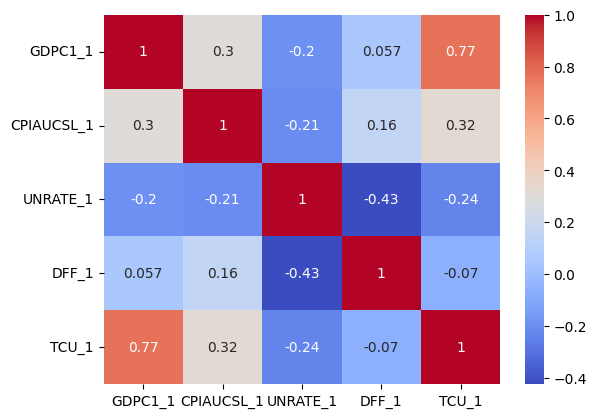

In [4]:
target = pd.Series(rgdp['GDPC1'])
X = pd.concat([rgdp,
               cpi.loc[rgdp.index],
               unrate.loc[rgdp.index],
               dff.loc[rgdp.index],
               tcu.loc[rgdp.index]], axis=1)
X = X.shift(1).dropna(how='any')
cols = X.columns.tolist()
X.columns = [col + "_1" for col in cols]
X_2 = X.shift(1)

target = target.loc[X.index]
time_idx = target.index


assert X.notna().all().all() == target.notna().all().all() == True, len(X) == len(target)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

y = target.values
# X = s.fit_transform(X.values)
X = X.values

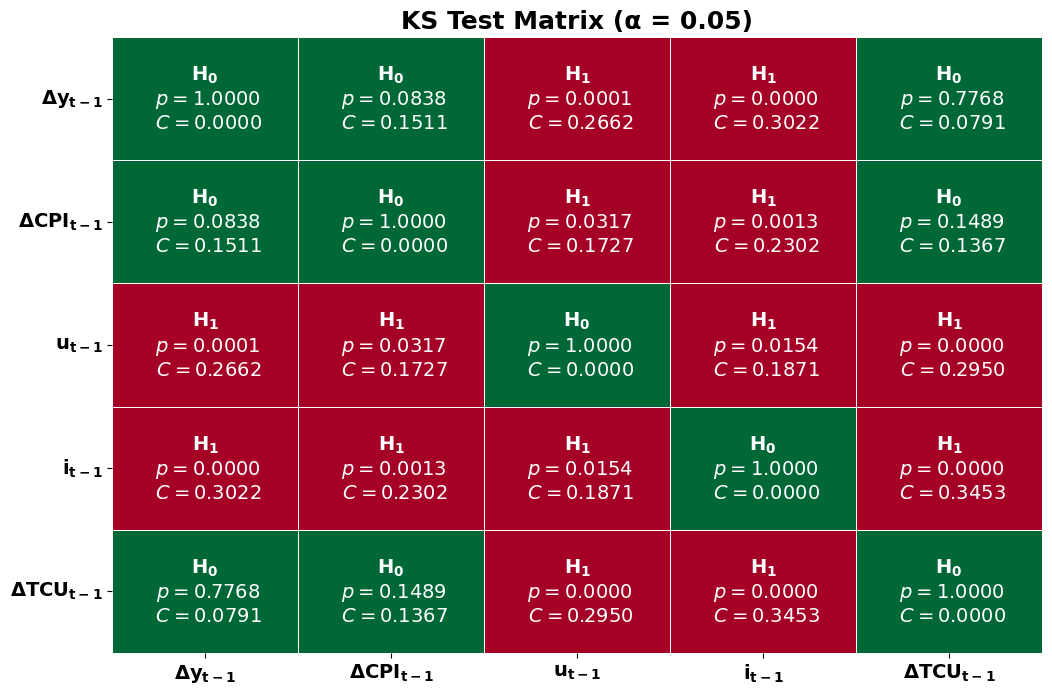

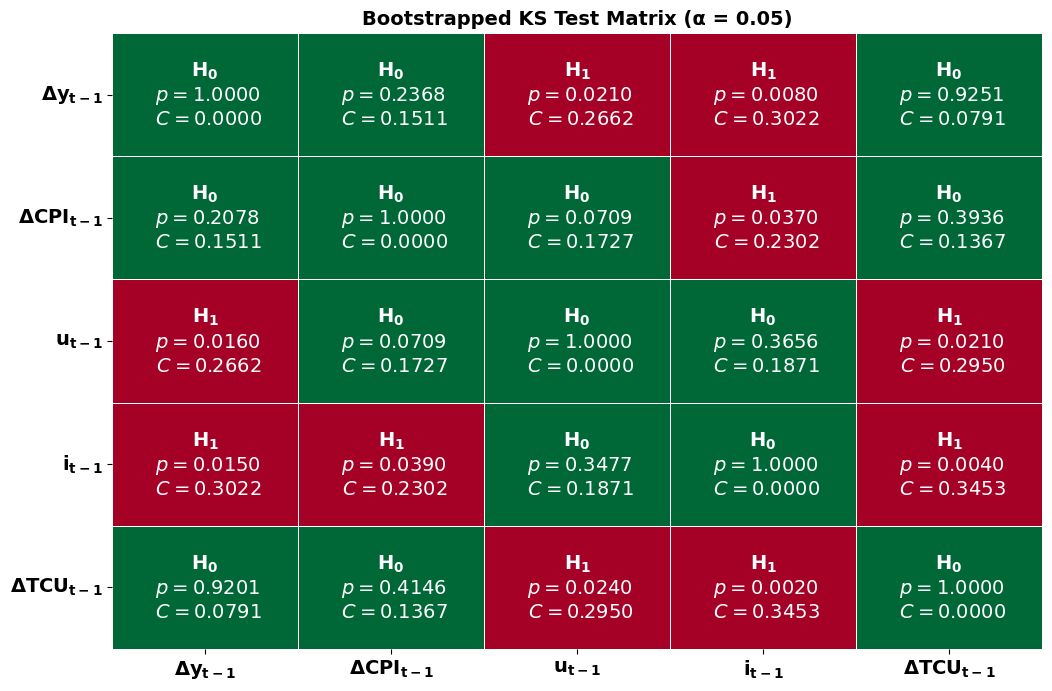

In [5]:
vars = [r"$\mathbf{\Delta y_{t-1}}$", r"$\mathbf{\Delta CPI_{t-1}}$", r"$\mathbf{u_{t-1}}$", r"$\mathbf{i_{t-1}}$", r"$\mathbf{\Delta TCU_{t-1}}$"]
tests = KS2Sample(X, display_plot=True, varnames=vars)
bs_tests = BootstrapKS2Samp(X, display_plot=True, n_bootstrap=1000, varnames=vars)

In [ ]:
tests[0]

In [ ]:
VIF(X)

In [ ]:
u_ar = AR1(X[:, 2], "n")
u_resid = X[1:, 2] - u_ar * X[:-1, 2]
u_target = X[1:, 0] - u_ar * X[:-1, 0]

cpi_ar = AR1(X[:, 1], "n")
cpi_resid = X[1:, 1] - cpi_ar * X[:-1, 1]
cpi_target = X[1:, 0] - cpi_ar * X[:-1, 0]

i_ar = AR1(X[:, 3], "n")
i_resid = X[1:, 3] - i_ar * X[:-1, 3]
i_target = X[1:, 0] - i_ar * X[:-1, 0]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_ccf(cpi_target, cpi_resid, ax=ax[0], lags=50)
ax[0].set_title(r"CCF between $\mathbf{\Delta y}$ and $\mathbf{\Delta CPI}$", fontsize=14, weight='bold')
ax[0].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[0].set_ylabel(r"$\mathbf{CCF(\Delta y, \Delta CPI)}$", fontsize=12, weight='bold')

plot_ccf(u_target, u_resid, ax=ax[1], lags=50)
ax[1].set_title(r"CCF between $\mathbf{\Delta y}$ and $\mathbf{u}$", fontsize=14, weight='bold')
ax[1].set_xlabel(r"Lags", fontsize=12, weight='bold')
ax[1].set_ylabel(r"$\mathbf{CCF(\Delta y, u)}$", fontsize=12, weight='bold')

plt.suptitle(r"Cross-Correlation Analysis of $\mathbf{y}$ with Exogenous Variables", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('./paper/fig/ccf.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.figure(figsize=(8, 6)), plt.gca()
plot_ccf(i_target, i_resid, ax=ax, lags=50)
ax.set_title(r"CCF between $\mathbf{\Delta y}$ and $\mathbf{i}$", fontsize=14, weight='bold')
ax.set_xlabel(r"Lags", fontsize=12, weight='bold')
ax.set_ylabel(r"$\mathbf{CCF(\Delta y, i)}$", fontsize=12, weight='bold')
plt.show()

In [ ]:
# Lagged Exog correlations
corr_df = pd.concat([target, cpi, unrate], axis=1)
corr_df.columns = ['y', 'CPI_0', 'u_0']
for lag in range(1, 6):
    corr_df[f'CPI_{lag}'] = cpi.shift(lag)
    corr_df[f'u_{lag}'] = unrate.shift(lag)
corr_df.dropna(inplace=True)
corr_df.corr()['y']


In [ ]:
ols = OLS(X, y)
fit = ols.fit(diagnosis_trend="n")
fit.XT_e, fit.beta, fit.coefs, fit.intercept

In [ ]:
n = len(fit.resid)
x = np.arange(n)
m, b = np.polyfit(x, fit.resid, 1)

line = m * x + b

outliers = np.where((fit.resid < np.quantile(fit.resid, 0.005)) | (fit.resid > np.quantile(fit.resid, 0.995)))[0]

plt.scatter(pd.DatetimeIndex(time_idx), fit.resid)
plt.plot(pd.DatetimeIndex(time_idx), line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")
plt.scatter(pd.DatetimeIndex(time_idx)[outliers], fit.resid[outliers], color='red', label=r'Outliers ($\alpha=0.01$ two-tailed)')


plt.title(r"Residuals Over Time", fontsize=18, weight='bold')
plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$y_i - \hat{y}_i$", fontsize=14)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(pct_fmt))

plt.grid(alpha=1, linestyle=":")
plt.tick_params(axis="x", rotation=0, labelsize=10)
plt.tick_params(axis="y", rotation=0, labelsize=10)

plt.legend(fontsize=12)
plt.show()

In [ ]:
plt.plot(pd.DatetimeIndex(time_idx), y, label=r"$y_i$")
plt.plot(pd.DatetimeIndex(time_idx), fit.fitted_values, label=r"$\hat{y}_i$", linestyle="--")

plt.title(r"Fitted vs. Observed Values", fontsize=18, weight='bold')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(bn_dollar_fmt))

plt.grid(alpha=1, linestyle=":")
plt.tick_params(axis="x", rotation=0, labelsize=10)
plt.tick_params(axis="y", rotation=0, labelsize=10)

plt.ylabel(r"$y_i$", fontsize=14)
plt.xlabel(r"$t$", fontsize=14)

plt.legend(fontsize=12)
plt.show()

In [ ]:
fit.resid_heteroske

In [ ]:
# print(ols.predict(X_test))
fit.resid_normality

In [ ]:
fit.resid_stationarity

In [ ]:
fit.resid_autocorr
all(t.reject == False for t in fit.resid_autocorr)

In [ ]:
fit.qq(line="45", band=0.95)

In [ ]:
from scipy.stats import norm, t
fig = plt.figure(figsize=(8,6))
plt.hist(fit.resid, bins=20, density=True, alpha=.75)
mu, std = norm.fit(fit.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ts = t.fit(fit.resid)
t_fitted = t.pdf(x, ts[0], ts[1], ts[2])


plt.plot(x, p,linewidth=2, label=rf"Gaussian Fit [$\mu$={mu:.2f}, $\sigma$={std:.2f}]", color="orange", linestyle="-")
plt.plot(x, t_fitted, linewidth=2, label=rf"t-Distribution Fit [df={ts[0]:.2f}]", linestyle="-", color="blue")

plt.title(r"Residuals' Distribution", fontsize=18, weight='bold')
plt.xlabel(r"$Residuals$", fontsize=14)
plt.ylabel(r"$Density$", fontsize=14)
plt.grid(alpha=1, linestyle=":", color="gray")
plt.legend(fontsize=12, loc='upper left')
plt.show()

ts

In [ ]:
unrate.describe()

In [ ]:
sorted(fit.resid_autocorr, key=lambda x: x.pval)

In [ ]:
pred_set = s.transform(np.array([23_548.210, 323.364, 4.0]).reshape(1, -1))
pred = ols.predict(pred_set)[0]

np.array([pred, (pred - 23_770.98) / 23_770.98 * 100]).round(2)


In [ ]:
fit.HC_test